In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV

# Read data from training set

In [2]:
data = pd.read_csv('train_data.csv')
data_test = pd.read_csv('test_data.csv')
data.head()

,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,type of MM_0,...,alkaline phosphatise (ALP),total protein,albumin,glucose,pleural lactic dehydrogenise,pleural protein,pleural albumin,pleural glucose,C-reactive protein (CRP),class of diagnosis
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,65.0,7.1,3.8,141.0,458.0,4.1,2.2,25.0,101.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,62.0,6.7,4.1,93.0,129.0,0.0,0.0,76.0,24.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,46.0,5.5,2.7,100.0,323.0,4.9,2.6,23.0,67.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,63.0,5.6,3.2,119.0,343.0,4.6,2.8,65.0,34.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,52.0,7.6,3.9,94.0,545.0,5.5,3.3,29.0,78.0,0.0


# Create handles for test and training data

In [3]:
continuuous_features = ['age', 'duration of asbestos exposure',
                        'duration of symptoms', 'white blood',
                        'cell count (WBC)', 'platelet count (PLT)',
                        'sedimentation', 'blood lactic dehydrogenise (LDH)',
                        'alkaline phosphatise (ALP)', 'total protein',
                        'albumin', 'glucose', 'pleural lactic dehydrogenise',
                        'pleural protein', 'pleural albumin',
                        'pleural glucose', 'C-reactive protein (CRP)']

data_continuous = data[continuuous_features]
data_categorical = data.drop(continuuous_features, axis=1)
continuous_names = data_continuous.columns[:]
categorical_names = data_categorical.columns[:]


data_independent = data.drop(['class of diagnosis'], axis=1)
data_dependent = data['class of diagnosis']

data_test_independent = data_test.drop(['class of diagnosis'], axis=1)
data_test_dependent = data_test['class of diagnosis']

# Prepare data for SVM model

In order to improve the SVM's performance we normalize each column containing continuous features such that mean of each such column is equal to 0 and variance is equal to 1.

In [4]:
data[continuous_names] = data[continuous_names].apply(
    lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

data_test[continuous_names] = data_test[continuous_names].apply(
    lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

In [5]:
data.head()

,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,type of MM_0,...,alkaline phosphatise (ALP),total protein,albumin,glucose,pleural lactic dehydrogenise,pleural protein,pleural albumin,pleural glucose,C-reactive protein (CRP),class of diagnosis
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.004232,0.106617,0.093429,0.075274,-0.010639,0.023829,0.029923,-0.161152,0.403727,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.010928,0.028185,0.148985,-0.057690,-0.054913,-0.588112,-0.470077,0.181130,-0.433230,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.046642,-0.207109,-0.110275,-0.038300,-0.028806,0.143232,0.120832,-0.174574,0.034161,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.008696,-0.187501,-0.017682,0.014332,-0.026115,0.098456,0.166286,0.107305,-0.324534,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-0.033249,0.204656,0.111948,-0.054920,0.001069,0.232784,0.279923,-0.134306,0.153727,0.0


# Hyper parameter tuning

Since general SVC doesn't work good with linear kernel I use separate function to create a model using such kernel(LinearSVC).

In [26]:
grid_parameters = {
    'C': [.000001, .00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000, 100000],
    'loss': ['hinge', 'squared_hinge'],
    'random_state': [1234]
}

svc = svm.LinearSVC()
clf = GridSearchCV(svc, grid_parameters, cv=5, scoring='recall')
clf.fit(data_independent, data_dependent)
print(clf.best_params_)
print(accuracy_score(clf.predict(data_test_independent), data_test_dependent))


{'C': 0.0001, 'loss': 'squared_hinge', 'random_state': 1234}
0.215384615385


As we can see, data cannot be linearly divided

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf', 'random_state': 1234}
             precision    recall  f1-score   support

        0.0       0.79      0.88      0.83        50
        1.0       0.33      0.20      0.25        15

avg / total       0.68      0.72      0.70        65



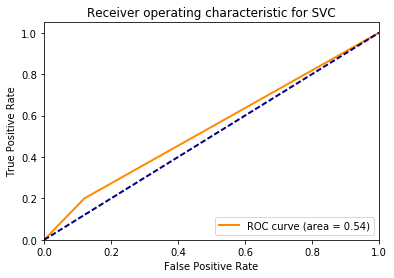

In [60]:
grid_parameters = {
    'C': [.0001, .001, .01, .1, 1, 10, 100, 1000, 10000],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': [.0001, .001, .01, .1, 1, 10],
    'random_state': [1234]    
}

clf = GridSearchCV(svm.SVC(), grid_parameters, cv=5, scoring='recall')
clf.fit(data_independent, data_dependent)

print(clf.best_params_)
print(classification_report(data_test_dependent, clf.best_estimator_.predict(data_test_independent)))

fpr, tpr, thresholds = roc_curve(data_test_dependent, clf.best_estimator_.predict(data_test_independent))
#plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for SVC')
plt.legend(loc="lower right")
plt.show()